In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('Is GPU available:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# ハイパーパラメータ等（エポック数、バッチサイズ、学習率、デバイス）
n_epochs = 10
batchsize = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIAR10データセットをロードし、上で定義したtransformをかける. 
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
cifar10_train = datasets.CIFAR10(root = './data',
                                 train = True,
                                 transform = tf,
                                 download = True)
cifar10_validation = datasets.CIFAR10(root = './data',
                                      train = False,
                                      transform = tf)

# num_workersは複数コアがある場合にいくつのコアをデータのロードに使うからしい　影響はよくわからない
cifar10_train_loader = DataLoader(cifar10_train, batch_size = batchsize, shuffle = True, num_workers = 4)
cifar10_validation_loader = DataLoader(cifar10_validation, batch_size = batchsize, shuffle = False, num_workers = 4)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # cifar10の１0個のクラス

print('the number of training data', len(cifar10_train))
print('the number of validation data', len(cifar10_validation))

Files already downloaded and verified
the number of training data 50000
the number of validation data 10000


tensor([[0, 9, 3, 5, 3],
        [9, 3, 7, 8, 9],
        [1, 1, 3, 0, 6],
        [1, 3, 0, 7, 4],
        [4, 9, 6, 3, 1]])
[['plane' 'truck' 'cat' 'dog' 'cat']
 ['truck' 'cat' 'horse' 'ship' 'truck']
 ['car' 'car' 'cat' 'plane' 'frog']
 ['car' 'cat' 'plane' 'horse' 'deer']
 ['deer' 'truck' 'frog' 'cat' 'car']]


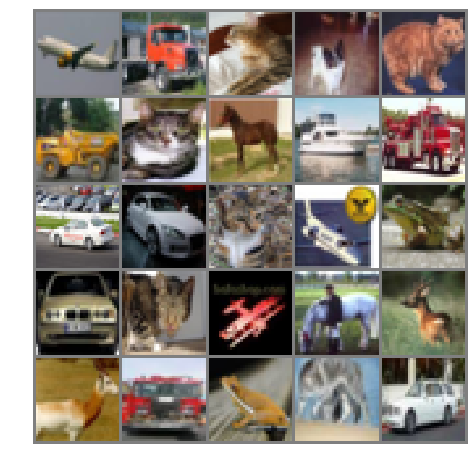

In [4]:
# make_gridを用いた画像データの可視化(Todo: n**2枚数の画像を正方形に並べて表示しかこれだとできないのでもうちょい柔軟に)
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5 # 描画のために正規化を戻す
    plt.figure(figsize = (8, 8))
    # PyTorchでは画像は(channel, height, width)で, pltでは(height, width, channel)なのでnp.transposeでひっくり返す
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
n_row = 5 # 列数(行数も同じ)
n_show = n_row ** 2 # 表示する画像データの枚数
# iterでDataLoaderを包むと.next()で次のミニバッチを取り出せる
images, labels = iter(cifar10_train_loader).next()
images, labels = images[:n_show], labels[:n_show]

# クラスラベルのインデックスをクラス名に変換
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
# make_grid()はいい感じに画像を１つにまとめてくれる、 n_rowで列数を指定し、columnは計算してくれる. paddingは画像同士の間隔
imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print(labels.view(n_row, n_row))
print(labels_name)

In [5]:
# cifar10分類のための畳み込みニューラルネットワーク
class CNN_CIFAR10(nn.Module):
    def __init__(self):
        super(CNN_CIFAR10, self).__init__()
        # 畳み込みとバッチノルム、活性化関数とプーリングをある程度まとめて扱う
        self.layers1 = nn.Sequential(
                            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers2 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(64),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layers3 = nn.Sequential(
                            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
                            nn.BatchNorm2d(128),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        #　畳み込み層のあとに１次元にまとめて全結合層に入れ、最終的に１０クラス分類に帰着する
        self.dr1 = nn.Dropout(0.3) # ドロップアウト、引数は無効化する確率
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.rl1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        out = self.layers1(x)
        out = self.layers2(out)
        out = self.layers3(out)
        
        # 畳み込みが終わったので全結合層に入れるために１次元にサイズ変換
        out = out.view(out.size(0), -1)
        out = self.dr1(out)
        out = self.rl1(self.fc1(out))
        out = self.fc2(out)
        return out

In [6]:
# ネットワークを実体化、ロス関数とオプティマイザを定義
net = CNN_CIFAR10()
net = net.to(device) # .to(device)でCPU/GPUに送信できる

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー誤差. ソフトマックスも含む
optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = 0.0005)

# モデルのtarinableな(勾配を要求する)パラメータの数をカウントする（.numel()で要素数の合計がわかる）
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、ロス関数、プティ米座の表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 786186

Model:
 CNN_CIFAR10(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dr1): Dropout(p=0.3)
  (fc1): Linear(in_features=204

In [7]:
# １エポック分の学習を行う関数
def train(train_loader):
    net.train() # モデルを学習モードにする
    running_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) # モデルとTensorを同じインタフェースでCPU/GPU転送できる 
        outputs = net(inputs)
        # outputsとtargetsの順番は変えてはいけない. 後, one-hot-encodingは向こうでやってくれる
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # .item()でスカラ値を単要素Tensorから取り出す
        
    train_loss = running_loss / len(train_loader) # lossはミニバッチサイズ依存がないように正規化されているので、ミニバッチの数で割る.
    return train_loss # 戻り値は訓練誤差

In [8]:
# バリデーションを行う関数
def validation(validation_loader):
    net.eval() # モデルを評価モードにする
    validation_loss = 0
    correct = 0 # 正解数
    
    with torch.no_grad(): # 評価時には不要なので勾配を追跡させない
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            
            validation_loss += loss_fn(outputs, targets).item() # 今回backwardしないので一気にスカラ値にしてしまう
            preds = outputs.max(1, keepdim = True)[1] # 一番ソフトマックスに入れる前の値が大きなもののインデックス（ラベル）を取得
            correct += preds.eq(targets.view_as(preds)).sum().item() # 正解ラベルと比較して正解数をカウント
    
    validation_loss = validation_loss / len(validation_loader)
    validation_accuracy = correct / len(validation_loader.dataset) # accuracyはデータの数で割るので.datasetがつく
    return validation_loss, validation_accuracy # ロスと正答率を返す

In [9]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで　←　モデル状態の保存は他にもいろいろある？）
DIRNAME = './cifar10_result'
train_loss_list = []
validation_loss_list = []
validation_accuracy_list = []
for epoch in range(n_epochs):
    train_loss = train(cifar10_validation_loader)
    validation_loss, validation_accuracy = validation(cifar10_validation_loader)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    validation_accuracy_list.append(validation_accuracy)
    
    print('epoch[%d/%d] loss:%1.4f validation_loss:%1.4f validation_accuracy:%1.4f' % \
                                (epoch+1, n_epochs, train_loss, validation_loss, validation_accuracy))

if not os.path.exists(DIRNAME):
    os.mkdir(DIRNAME)
np.save(DIRNAME + 'train_loss_list.npy', np.array(train_loss_list))
np.save(DIRNAME + 'validation_loss_list.npy', np.array(validation_loss_list))
np.save(DIRNAME + 'validation_accuracy_list.npy', np.array(validation_accuracy_list))

torch.save(net.state_dict(), DIRNAME + 'CNN_CIFAR10.pth')

epoch[1/10] loss:1.6429 validation_loss:1.5101 validation_accuracy:0.4707
epoch[2/10] loss:1.3353 validation_loss:1.2130 validation_accuracy:0.5592
epoch[3/10] loss:1.1637 validation_loss:1.1035 validation_accuracy:0.6006
epoch[4/10] loss:1.0388 validation_loss:0.9993 validation_accuracy:0.6350
epoch[5/10] loss:0.9265 validation_loss:0.8428 validation_accuracy:0.6944
epoch[6/10] loss:0.8315 validation_loss:0.7638 validation_accuracy:0.7280
epoch[7/10] loss:0.7577 validation_loss:0.6544 validation_accuracy:0.7769
epoch[8/10] loss:0.6851 validation_loss:0.6383 validation_accuracy:0.7748
epoch[9/10] loss:0.6168 validation_loss:0.5180 validation_accuracy:0.8229
epoch[10/10] loss:0.5478 validation_loss:0.4587 validation_accuracy:0.8393


In [10]:
# 学習ログの読み込み（このjupyter notebookを実行する上で必要はないが、np.save/np.loadの使い方としてメモ）
train_loss_list = np.load(DIRNAME + 'train_loss_list.npy')
validation_loss_list = np.load(DIRNAME + 'validation_loss_list.npy')
validation_accuracy_list = np.load(DIRNAME + 'validation_accuracy_list.npy')

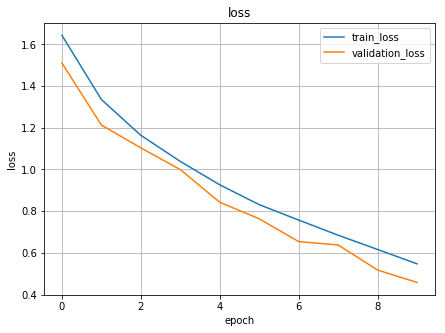

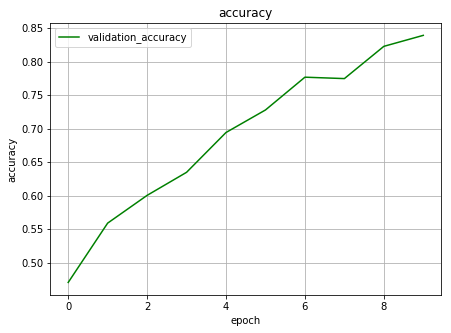

In [11]:
# 学習ログ（lossとaccuracy)の可視化
# loss
plt.figure(figsize = (7, 5))
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(validation_loss_list, label = 'validation_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# accuracy
plt.figure(figsize = (7, 5))
plt.plot(validation_accuracy_list, 'g-', label = 'validation_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [12]:
# モデルの重みの読み込み（このjupyter notebookを実行する上で必要はないが、torch.save/torch.loadの使い方としてメモ）
params = torch.load(DIRNAME + 'CNN_CIFAR10.pth')
net = CNN_CIFAR10()
net.load_state_dict(params)

In [13]:
# 読み込んだ学習済みモデルを使って推論のテスト
# ここで用いているデータはvaidationデータと同じなので本来testデータには不適切だが、簡便のため同じものでテスト

cifar10_test = datasets.CIFAR10(root = './data',
                               train = False,
                               transform = tf)
cifar10_test_loader = DataLoader(cifar10_test, batch_size = batchsize, shuffle = True)

with torch.no_grad():
    net.eval()
    inputs, targets = iter(cifar10_test_loader).next()
    outputs = net(inputs)
    preds = outputs.max(1, keepdim = True)[1].view(-1)
    accuracy = preds.eq(targets.view_as(preds)).sum().item() / len(inputs)
print('accuracy:%2.2f' % (accuracy*100) + '%')

accuracy:87.50%


prediction:
 [['frog' 'truck' 'dog' 'horse' 'horse']
 ['bird' 'frog' 'horse' 'dog' 'car']
 ['dog' 'car' 'horse' 'dog' 'car']
 ['deer' 'deer' 'car' 'ship' 'car']
 ['frog' 'car' 'dog' 'cat' 'horse']]
ground truth:
 [['frog' 'truck' 'dog' 'horse' 'horse']
 ['plane' 'frog' 'horse' 'cat' 'car']
 ['dog' 'car' 'horse' 'cat' 'car']
 ['deer' 'deer' 'car' 'ship' 'car']
 ['frog' 'car' 'dog' 'cat' 'horse']]


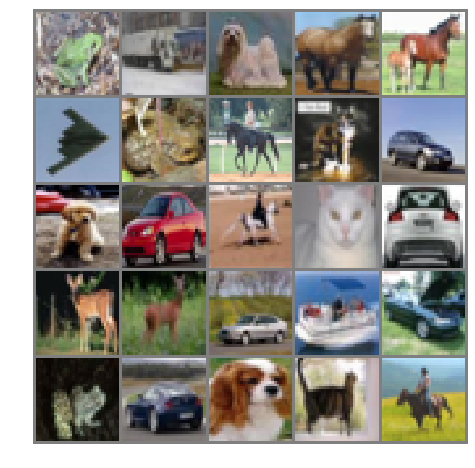

In [14]:
# 推論結果の可視化
n_row = 5 # 列数(行数も同じ)
n_show = n_row ** 2 # 表示する画像データの枚数
images, labels, predict_labels = inputs[:n_show], targets[:n_show], preds[:n_show]

# クラスラベルのインデックスをクラス名に変換
labels_name = np.array([classes[l] for l in labels.numpy()]).reshape(n_row, n_row)
predict_labels_name = np.array([classes[l] for l in predict_labels.numpy()]).reshape(n_row, n_row)

imshow(make_grid(images, nrow = n_row, padding = 1))
plt.axis('off')
print('prediction:\n', predict_labels_name)
print('ground truth:\n', labels_name)

In [15]:
# どんな画像について間違えたのか抽出
wrong_predicted_images = []
correct_labels = []
wrong_predicted_labels = []
wrong_predicted_outputs = []

for i, t, p, o in zip(inputs, targets, preds, outputs):
    if t.item() != p.item():
        wrong_predicted_images.append(i)
        correct_labels.append(t)
        wrong_predicted_labels.append(p)
        wrong_predicted_outputs.append(o)

wrong prediction:
['bird' 'dog' 'dog' 'truck' 'cat']
['horse' 'cat' 'dog' 'horse' 'dog']
['horse' 'cat' 'dog' 'frog' 'dog']
['bird']

ground truth:
['plane' 'cat' 'cat' 'plane' 'frog']
['dog' 'dog' 'deer' 'dog' 'cat']
['cat' 'frog' 'cat' 'cat' 'cat']
['plane']


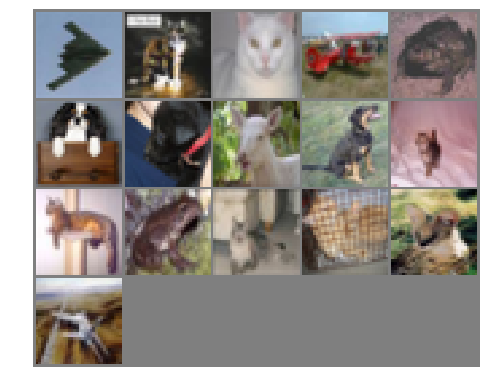

In [16]:
# どんな画像について間違えたのか可視化してみる
correct_labels_name = np.array([classes[l] for l in correct_labels])
wrong_predicted_labels_name = np.array([classes[l] for l in wrong_predicted_labels])

imshow(make_grid(wrong_predicted_images, nrow = n_row, padding = 1))
plt.axis('off')
print('wrong prediction:')
for l in range(0, len(wrong_predicted_labels_name), n_row):
    print(wrong_predicted_labels_name[l:l+n_row])
print()
print('ground truth:')
for l in range(0, len(correct_labels_name), n_row):
    print(correct_labels_name[l:l+n_row])

In [17]:
# 上のまとめた画像において左上から順に確率を表示(％)
# 間違えたものがどれくらいの確率で間違えたのか出力にSoftmaxをかけて見てみる
# 大体人間から見ても似ているものについて間違えており、確率的にもそうなっていることがわかる
predict_prob = []
for wo in wrong_predicted_outputs:
    predict_prob.append(F.softmax(wo, dim = 0).numpy())
predict_prob = np.array(predict_prob)

predict_prob_dict = {}
for i, c in enumerate(classes):
    predict_prob_dict[c] = predict_prob[:, i] * 100
    
pd.options.display.float_format = '{:.1f}'.format
df = pd.DataFrame(predict_prob_dict)
df

,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
0,72.9,0.0,0.1,0.0,0.0,0.1,0.0,26.9,0.0,0.0
1,7.0,0.0,43.2,0.6,43.7,0.0,5.1,0.1,0.0,0.3
2,0.8,0.0,17.9,2.0,72.8,0.1,1.4,1.5,3.5,0.0
3,0.1,6.9,0.0,1.0,0.6,0.0,16.7,12.1,9.6,52.9
4,15.1,0.1,49.0,0.2,9.3,25.9,0.2,0.0,0.1,0.1
5,1.2,0.0,7.7,0.2,26.2,0.0,47.9,0.0,16.7,0.1
6,1.1,0.3,53.5,0.1,41.1,3.5,0.0,0.1,0.2,0.0
7,32.1,0.0,1.7,11.7,51.2,0.1,3.2,0.0,0.0,0.0
8,31.7,0.0,3.5,22.7,5.5,0.6,35.6,0.2,0.0,0.0
9,4.6,0.0,18.8,16.9,57.7,0.7,0.8,0.4,0.0,0.0
